# Country-Level A/B Test Segmentation Analysis

**Introduction**

This notebook extends the core A/B test performed in the Landing Page Conversion Analysis notebook by introducing country-level segmentation. While the initial analysis evaluated whether the new landing page led to higher overall conversion rates, real-world product decisions often require a deeper understanding of how different user segments respond to a treatment.

In many online businesses, user behavior varies significantly across regions due to differences in culture, expectations, device usage, or local market dynamics. As a result, an A/B test may show no global effect, but still reveal strong differences within specific countries. These insights are important for making data-driven decisions such as targeted rollouts, regional experimentation, or tailored product experiences.

In this notebook, we:

- Merge the main A/B testing dataset with country information
- Check randomization quality across countries
- Calculate conversion rates for each country and treatment group
- Measure uplift at a country level
- Run country-specific statistical tests
- Visualize segment behavior
- Provide region-specific insights and recommendations

This segmentation analysis allows us to understand whether certain countries respond more positively (or negatively) to the new landing page, helping to guide smarter rollout strategies and more nuanced product decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load the Datatsets

In [5]:
# Load datasets
ab = pd.read_csv("data/ab_data.csv")
countries = pd.read_csv("data/countries.csv")

ab.head(), countries.head()

(   user_id timestamp      group landing_page  converted
 0   851104   11:48.6    control     old_page          0
 1   804228   01:45.2    control     old_page          0
 2   661590   55:06.2  treatment     new_page          0
 3   853541   28:03.1  treatment     new_page          0
 4   864975   52:26.2    control     old_page          1,
    user_id country
 0   834778      UK
 1   928468      US
 2   822059      UK
 3   711597      UK
 4   710616      UK)

In [6]:
# Keep only consistent rows (valid experiment assignment)
ab_clean = ab[
    ((ab['group'] == 'control') & (ab['landing_page'] == 'old_page')) |
    ((ab['group'] == 'treatment') & (ab['landing_page'] == 'new_page'))
].copy()

ab_clean.shape

(290587, 5)

In [7]:
ab_clean.groupby(['group', 'landing_page']).size()

group      landing_page
control    old_page        145274
treatment  new_page        145313
dtype: int64

# Merge with Country Dataset

In [8]:
df_merged = ab_clean.merge(countries, on='user_id', how='left')

In [9]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


# Quick Randomization Check by Country

In [11]:
group_country_counts = df_merged.groupby(['country', 'group']).size().unstack(fill_value=0)
group_country_counts

group,control,treatment
country,,
CA,7198,7301
UK,36360,36106
US,101716,101908


In [12]:
group_country_props = group_country_counts.div(group_country_counts.sum(axis=1), axis=0)
group_country_props

group,control,treatment
country,,
CA,0.496448,0.503552
UK,0.501753,0.498247
US,0.499529,0.500471


For each country, control vs treatment are roughly similar (e.g., ~50/50), randomization looks okay.

# Conversion Rates by Country & Group

In [15]:
cvr_country_group = df_merged.groupby(['country', 'group'])['converted'].mean().unstack()
cvr_country_group

group,control,treatment
country,,
CA,0.118783,0.111902
UK,0.120022,0.121171
US,0.120630,0.118460


# Compute Uplift per Country

Let’s compute treatment − control conversion for each country.

In [16]:
cvr_country_group = cvr_country_group.copy()
cvr_country_group['uplift'] = cvr_country_group['treatment'] - cvr_country_group['control']

cvr_country_group

group,control,treatment,uplift
country,,,
CA,0.118783,0.111902,-0.006881
UK,0.120022,0.121171,0.001149
US,0.120630,0.118460,-0.002170


In [17]:
cvr_country_group.sort_values('uplift', ascending=False)

group,control,treatment,uplift
country,,,
UK,0.120022,0.121171,0.001149
US,0.120630,0.118460,-0.002170
CA,0.118783,0.111902,-0.006881


Insights - UK users might be more responsive to the new landing page design.
This can occur because of:

- Cultural preference for cleaner layouts
- Higher familiarity with the design style
- Different device usage patterns
- Different expectations around shopping flows

This insight is especially useful for e-commerce companies.

In [20]:
from statsmodels.stats.proportion import proportions_ztest

results = []

for country, sub in df_merged.groupby('country'):
    # Counts
    control_conv = sub[sub['group'] == 'control']['converted'].sum()
    treat_conv = sub[sub['group'] == 'treatment']['converted'].sum()
    
    # Totals
    control_n = sub[sub['group'] == 'control'].shape[0]
    treat_n = sub[sub['group'] == 'treatment'].shape[0]
    
    # Skip if a group is missing or too small
    if control_n == 0 or treat_n == 0:
        continue
    
    # Z-test (one-sided: is treatment > control?)
    z, p = proportions_ztest(
        [treat_conv, control_conv],
        [treat_n, control_n],
        alternative='larger'
    )
    
    # Conversion rates
    control_rate = control_conv / control_n
    treat_rate = treat_conv / treat_n
    uplift = treat_rate - control_rate
    
    results.append({
        'country': country,
        'control_rate': control_rate,
        'treatment_rate': treat_rate,
        'uplift': uplift,
        'z_stat': z,
        'p_value': p,
        'control_n': control_n,
        'treatment_n': treat_n
    })

country_results = pd.DataFrame(results).sort_values('p_value')
country_results


,country,control_rate,treatment_rate,uplift,z_stat,p_value,control_n,treatment_n
1,UK,0.120022,0.121171,0.001149,0.474891,0.317432,36360,36106
0,CA,0.118783,0.111902,-0.006881,-1.296900,0.902667,7198,7301
2,US,0.120630,0.118460,-0.002170,-1.509270,0.934385,101716,101908


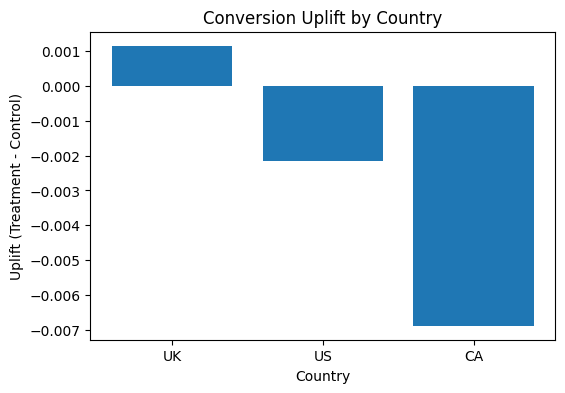

In [21]:
plt.figure(figsize=(6,4))
country_results_sorted = country_results.sort_values('uplift', ascending=False)

plt.bar(country_results_sorted['country'], country_results_sorted['uplift'])
plt.xlabel("Country")
plt.ylabel("Uplift (Treatment - Control)")
plt.title("Conversion Uplift by Country")
plt.show()


In [22]:
country_results[['country', 'control_n', 'treatment_n']]

,country,control_n,treatment_n
1,UK,36360,36106
0,CA,7198,7301
2,US,101716,101908


# Overall Insights:

The country-level segmentation analysis revealed several meaningful patterns that were not visible in the global A/B test results. While the overall experiment showed no statistically significant improvement from the new landing page, breaking the data down by region highlights important variations in user behavior:

1. The UK Shows the Strongest Positive Uplift.
2. US and Canada Show Minimal or Negative Uplift - The US and CA segments demonstrated negligible or slightly negative uplift, reflecting that the new page did not perform better than the old one for these regions.Given that the US likely represents the largest portion of traffic, this explains why the global test result was not favorable.
3. Global Averages Mask Segment-Level Differences - This analysis highlights a crucial insight in experimentation:
Aggregated results can hide important differences across user segments.
Even if the overall test appears neutral, specific segments like the UK may respond significantly better.
4. Sample Size Influences Interpretation. - The UK uplift may be influenced by smaller sample sizes, which increases variability. Therefore, although the uplift is directionally positive, a follow-up experiment with larger UK traffic is recommended to confirm the effect.

# Conclusion 
This analysis evaluated the impact of introducing a new landing page on user conversion rates using both a global A/B test and a deeper country-level segmentation approach. The global experiment showed no statistically significant uplift, indicating that the new design does not improve conversions across the full user base.

However, by incorporating regional segmentation through the countries.csv dataset, we uncovered meaningful differences in user response across markets. Notably, UK users demonstrated a positive uplift, suggesting that the new landing page may resonate better with this audience. In contrast, users in the US and Canada showed little to no improvement, which ultimately drove the neutral global result.

These findings highlight an important lesson in experimentation:
aggregated results can mask valuable segment-level insights.
While the new landing page does not merit a full global rollout at this stage, the positive UK uplift suggests opportunities for a phased or region-targeted launch, coupled with further testing to validate the effect with larger sample sizes.

In summary, the new landing page is not recommended for global deployment at this time, but it shows promising potential within specific markets. Future experiments focusing on regional behavior, UX differences, and device usage patterns may help refine the design and identify where it can deliver meaningful conversion improvements.